## Import Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
#!python -m pip install prophet
from prophet import Prophet

## Data Loading & Preliminary Exploration

In [2]:
# Load each sheet into a separate DataFrame
df1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

# Combine both dataframe
data = pd.concat([df1, df2], ignore_index=True)

# Display the first few rows of the dataframe
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Dataset Overview

In [3]:
# Basic info about data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [4]:
# Descriptive statistics for numerical variables
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


In [5]:
# Summary statistics for categorical variables
data.describe(include='object').T

,count,unique,top,freq
Invoice,1067371,53628,537434,1350
StockCode,1067371,5305,85123A,5829
Description,1062989,5698,WHITE HANGING HEART T-LIGHT HOLDER,5918
Country,1067371,43,United Kingdom,981330


## Data Cleaning

In [6]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing 'Customer ID' as they are essential for our analysis
data = data.dropna(subset=['Customer ID'])

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


In [7]:
data.shape

(824364, 8)

In [8]:
# Remove duplicate entries, if any
print(f"The dataset contains {data.duplicated().sum()} duplicate rows.")

data = data.drop_duplicates()

data.shape

The dataset contains 26479 duplicate rows.


(797885, 8)

In [9]:
# Handling canceled orders
# Considering 'Invoice' starting with 'C' as canceled orders

returns = data[data['Invoice'].astype(str).str.contains('C')]
purchases = data[~data['Invoice'].astype(str).str.contains('C')]

In [10]:
# Create a new column 'TransactionStatus'
data['TransactionStatus'] = data['Invoice'].astype(str).apply(lambda x: 'Canceled' if x.startswith('C') else 'Completed')

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionStatus
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Completed
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Completed
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Completed
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Completed
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Completed


In [11]:
# Removing StockCode anomalies

# Convert 'StockCode' to string type
data['StockCode'] = data['StockCode'].astype(str)

# Use regular expression to check if 'StockCode' contains only alphabets
non_numeric_stockcodes = data[data['StockCode'].str.contains('^[a-zA-Z]+$')]

# Count of rows where 'StockCode' contains only non-numeric characters
percent_non_numeric_stockcodes = (non_numeric_stockcodes.shape[0] / data.shape[0]) * 100

print(f"Number and percent of rows with non-numeric 'StockCode': {non_numeric_stockcodes.shape[0]}, {percent_non_numeric_stockcodes}")
non_numeric_stockcodes.head()

Number and percent of rows with non-numeric 'StockCode': 3350, 0.41986000488792247


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionStatus
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.0,12682.0,France,Completed
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.0,12636.0,USA,Completed
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.0,12362.0,Belgium,Completed
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.0,12533.0,Germany,Completed
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.0,15299.0,United Kingdom,Canceled


In [12]:
# Filter out rows where 'StockCode' contains only alphabetic characters
data = data[~data['StockCode'].str.contains('^[a-zA-Z]+$')]

data.shape

(794535, 9)

## Exploratory Data Analysis (EDA)

<ipython-input-13-53c04b150a60>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



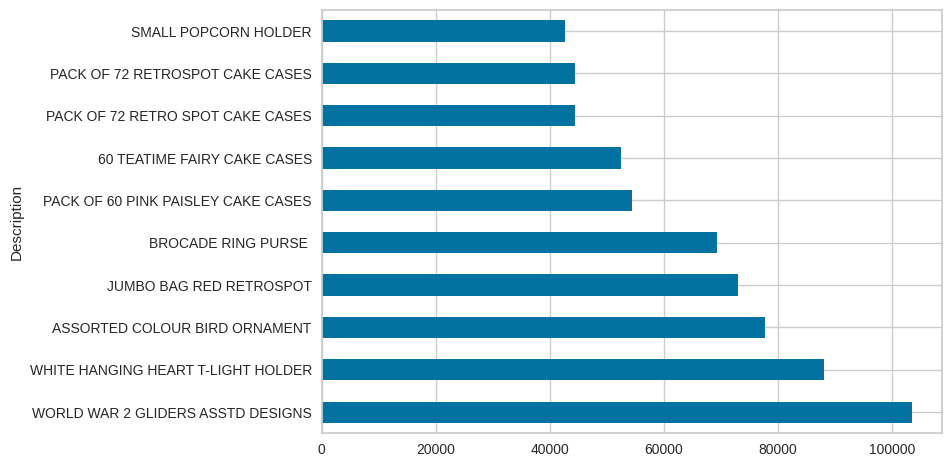

In [13]:
# Top products sold
top_products = data.groupby('Description').sum()['Quantity'].sort_values(ascending=False).head(10)
top_products.plot(kind='barh')
plt.show()

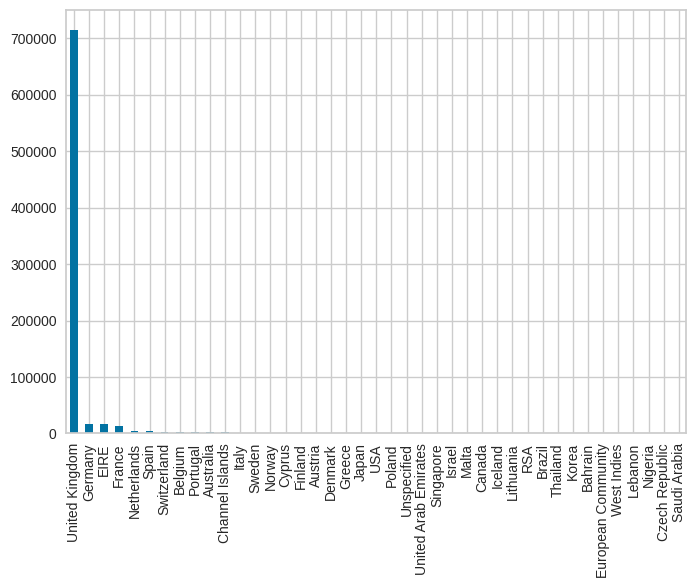

In [14]:
# Order count by country
country_counts = data['Country'].value_counts()
country_counts.plot(kind='bar')
plt.show()

In [15]:
temp = data[['Customer ID', 'Invoice', 'Country']].groupby(['Customer ID', 'Invoice', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries from which orders were made: {}'.format(len(countries)))

Number of countries from which orders were made: 41


In [16]:
dt = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [dt], layout = layout)
iplot(choromap, validate=False)

In [17]:
# Exploring cancellations or returns
returns['Quantity'] = returns['Quantity'].abs()  # Ensure quantities are positive for analysis
returns_summary = returns.groupby('Customer ID').sum()
print(returns_summary.head())

             Quantity   Price
Customer ID                  
12346.0         74232  360.10
12349.0             5   24.15
12352.0            66  856.99
12359.0           226   96.34
12360.0             1   40.00


<ipython-input-17-1fb10ae6276e>:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## Feature Engineering
### RFM Features
One can segment customers using RFM (Recency, Frequency, Monetary) analysis
- Recency: How recently have they made a purchase?
- Frequency: How often have they bought something?
- Monetary Value: How much money do they spend on average when making purchases?

In [18]:
# Calculate Recency for each customer
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)  # Snapshot date to calculate recency

# Aggregate data on a per-customer basis
customers = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days  # Recency
})

customers.head()

,InvoiceDate
Customer ID,
12346.0,326
12347.0,2
12348.0,75
12349.0,19
12350.0,310


In [19]:
# Calculate Frequency for each customer

# Calculate the total number of transactions made by each customer
total_transactions = data.groupby('Customer ID')['Invoice'].nunique().reset_index()
total_transactions.rename(columns={'Invoice': 'TotalTransactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = data.groupby('Customer ID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'TotalProductsPurchased'}, inplace=True)

# Merge the new features into the customers dataframe
customers = pd.merge(customers, total_transactions, on='Customer ID')
customers = pd.merge(customers, total_products_purchased, on='Customer ID')


customers.head()

,Customer ID,InvoiceDate,TotalTransactions,TotalProductsPurchased
0,12346.0,326,14,69
1,12347.0,2,8,2967
2,12348.0,75,5,2704
3,12349.0,19,4,1616
4,12350.0,310,1,196


In [20]:
#customers = customers.drop('Total_Transactions', axis=1)
#customers.head()

In [21]:
# Calculate Monetary value for each customer

# Calculate the total spend by each customer
data['TotalSpend'] = data['Price'] * data['Quantity']
total_spend = data.groupby('Customer ID')['TotalSpend'].sum().reset_index()

# Calculate the average transaction value for each customer
avg_transaction_value = total_spend.merge(total_transactions, on='Customer ID')
avg_transaction_value['AverageTransactionValue'] = avg_transaction_value['TotalSpend'] / avg_transaction_value['TotalTransactions']

# Merge the new features into the customers dataframe
customers = pd.merge(customers, total_spend, on='Customer ID')
customers = pd.merge(customers, avg_transaction_value[['Customer ID', 'AverageTransactionValue']], on='Customer ID')


customers.head()

,Customer ID,InvoiceDate,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue
0,12346.0,326,14,69,368.36,26.311429
1,12347.0,2,8,2967,4921.53,615.191250
2,12348.0,75,5,2704,1658.40,331.680000
3,12349.0,19,4,1616,3654.54,913.635000
4,12350.0,310,1,196,294.40,294.400000


### Product Diversity


In [22]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = data.groupby('Customer ID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'UniqueProductsPurchased'}, inplace=True)

# Merge the new feature into the customers dataframe
customers = pd.merge(customers, unique_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customers.head()

,Customer ID,InvoiceDate,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased
0,12346.0,326,14,69,368.36,26.311429,27
1,12347.0,2,8,2967,4921.53,615.191250,126
2,12348.0,75,5,2704,1658.40,331.680000,24
3,12349.0,19,4,1616,3654.54,913.635000,138
4,12350.0,310,1,196,294.40,294.400000,16


### Geographic Features

In [23]:
# Proportion of country
data['Country'].value_counts(normalize=True).head()

United Kingdom    0.899677
Germany           0.020969
EIRE              0.020075
France            0.016864
Netherlands       0.006319
Name: Country, dtype: float64

In [24]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = data.groupby(['Customer ID', 'Country']).size().reset_index(name='NumberOfTransactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('NumberOfTransactions', ascending=False).drop_duplicates('Customer ID')

# Create a binary column indicating whether the customer is from the UK or not (since majority of the transactions are from UK)
customer_main_country['IsUK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customers = pd.merge(customers, customer_main_country[['Customer ID', 'IsUK']], on='Customer ID', how='left')

# Display the first few rows of the customer_data dataframe
customers.head()

,Customer ID,InvoiceDate,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,IsUK
0,12346.0,326,14,69,368.36,26.311429,27,1
1,12347.0,2,8,2967,4921.53,615.191250,126,0
2,12348.0,75,5,2704,1658.40,331.680000,24,0
3,12349.0,19,4,1616,3654.54,913.635000,138,0
4,12350.0,310,1,196,294.40,294.400000,16,0


In [25]:
customers['IsUK'].value_counts()

1    5363
0     519
Name: IsUK, dtype: int64

### Cancellation Feature

In [26]:
# Calculate the total number of transactions made by each customer
total_transactions = data.groupby('Customer ID')['Invoice'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = data[data['TransactionStatus'] == 'Canceled']
cancellation_frequency = cancelled_transactions.groupby('Customer ID')['Invoice'].nunique().reset_index()
cancellation_frequency.rename(columns={'Invoice': 'CancellationFrequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customers dataframe
customers = pd.merge(customers, cancellation_frequency, on='Customer ID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customers['CancellationFrequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customers['CancellationRate'] = customers['CancellationFrequency'] / total_transactions['Invoice']

# Display the first few rows of the customer_data dataframe
customers.head()

,Customer ID,InvoiceDate,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,IsUK,CancellationFrequency,CancellationRate
0,12346.0,326,14,69,368.36,26.311429,27,1,2.0,0.142857
1,12347.0,2,8,2967,4921.53,615.191250,126,0,0.0,0.000000
2,12348.0,75,5,2704,1658.40,331.680000,24,0,0.0,0.000000
3,12349.0,19,4,1616,3654.54,913.635000,138,0,1.0,0.250000
4,12350.0,310,1,196,294.40,294.400000,16,0,0.0,0.000000


In [27]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5882 entries, 0 to 5881
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer ID              5882 non-null   float64
 1   InvoiceDate              5882 non-null   int64  
 2   TotalTransactions        5882 non-null   int64  
 3   TotalProductsPurchased   5882 non-null   int64  
 4   TotalSpend               5882 non-null   float64
 5   AverageTransactionValue  5882 non-null   float64
 6   UniqueProductsPurchased  5882 non-null   int64  
 7   IsUK                     5882 non-null   int64  
 8   CancellationFrequency    5882 non-null   float64
 9   CancellationRate         5882 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 505.5 KB


### Dealing with Outliers

InvoiceDate: 


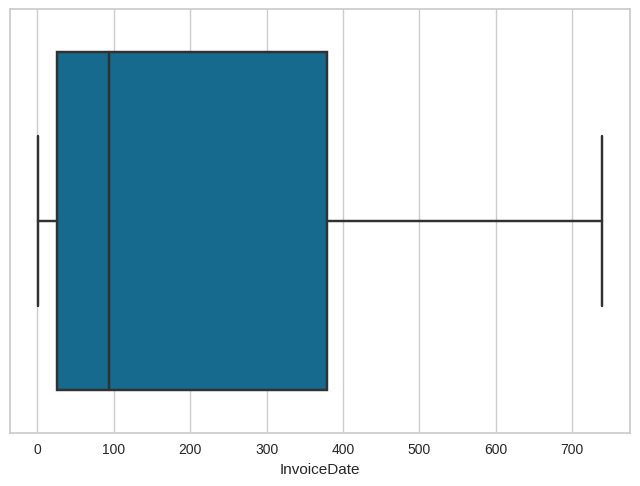

TotalTransactions: 


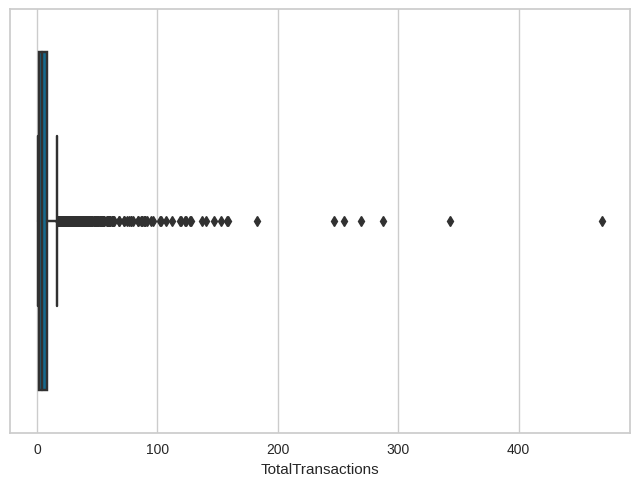

TotalProductsPurchased: 


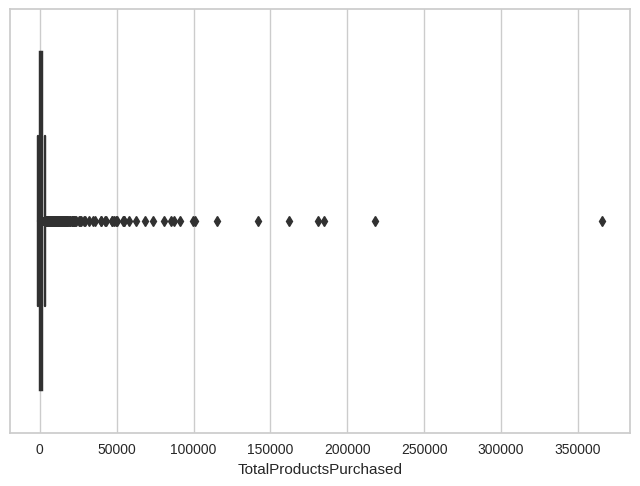

TotalSpend: 


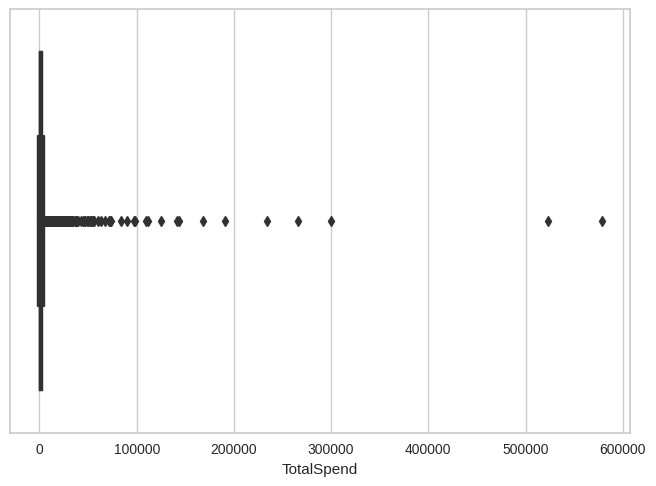

AverageTransactionValue: 


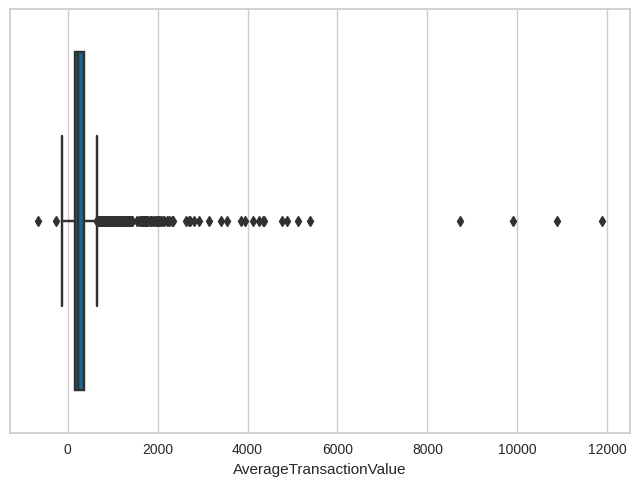

UniqueProductsPurchased: 


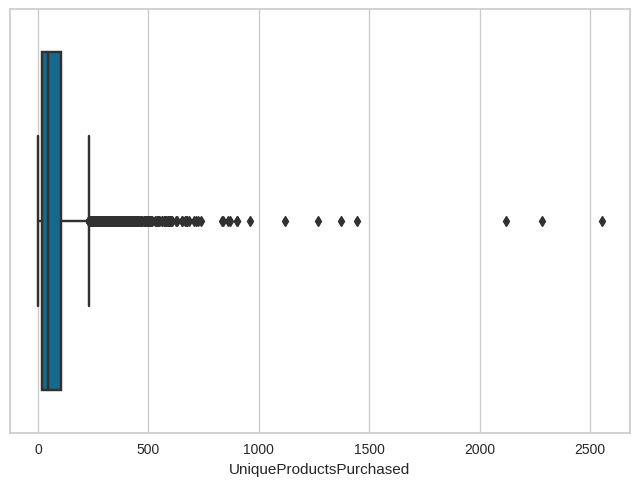

IsUK: 


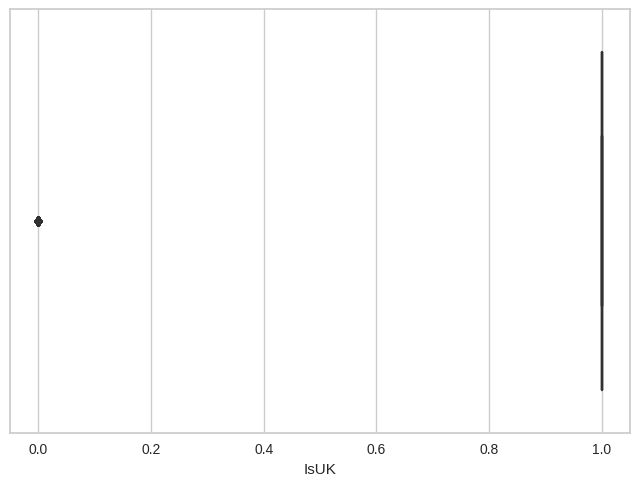

CancellationFrequency: 


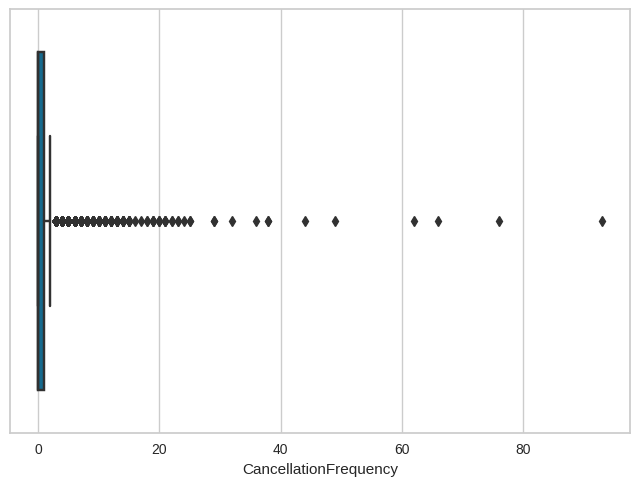

CancellationRate: 


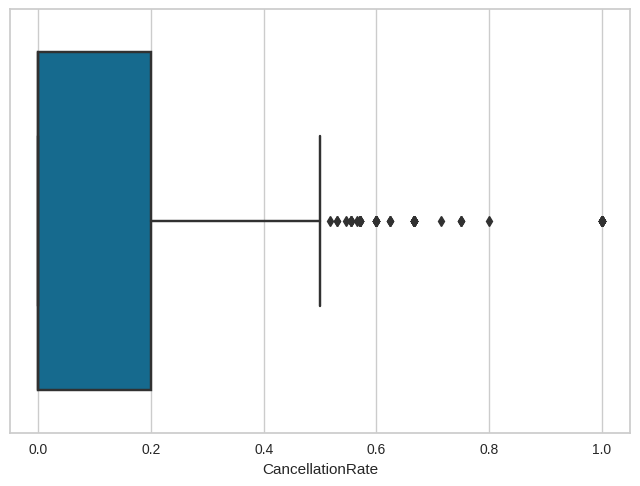

In [28]:
box_list = ['InvoiceDate','TotalTransactions','TotalProductsPurchased', 'TotalSpend', 'AverageTransactionValue', 'UniqueProductsPurchased', 'IsUK', 'CancellationFrequency', 'CancellationRate']
for i in box_list:
    print(str(i)+': ')
    ax = sns.boxplot(x=customers[str(i)])
    plt.show()

In [29]:
# Utilizing Isolation Forest algorithm to deal with outliers

# Select relevant columns
cols_to_use = [
    'TotalTransactions', 'TotalProductsPurchased',
    'TotalSpend', 'AverageTransactionValue', 'UniqueProductsPurchased',
    'CancellationFrequency', 'CancellationRate'
]

# Create a subset of the data using the columns of interest
subset = customers[cols_to_use]

# Initialize the model
iso_forest = IsolationForest(contamination=0.05)

# Fit the model and predict outliers
customers['OutlierScores'] = iso_forest.fit_predict(subset)

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customers['IsOutlier'] = [1 if x == -1 else 0 for x in customers['OutlierScores']]

# Display the first few rows of the customer_data dataframe
customers.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



,Customer ID,InvoiceDate,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,IsUK,CancellationFrequency,CancellationRate,OutlierScores,IsOutlier
0,12346.0,326,14,69,368.36,26.311429,27,1,2.0,0.142857,1,0
1,12347.0,2,8,2967,4921.53,615.191250,126,0,0.0,0.000000,1,0
2,12348.0,75,5,2704,1658.40,331.680000,24,0,0.0,0.000000,1,0
3,12349.0,19,4,1616,3654.54,913.635000,138,0,1.0,0.250000,1,0
4,12350.0,310,1,196,294.40,294.400000,16,0,0.0,0.000000,1,0


In [30]:
# Separate the outliers for analysis
outliers = customers[customers['IsOutlier'] == 1]

# Remove the outliers from the main dataset
customers_clean = customers[customers['IsOutlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customers_clean = customers_clean.drop(columns=['OutlierScores', 'IsOutlier'])

# Reset the index of the cleaned data
customers_clean.reset_index(drop=True, inplace=True)

customers_clean.shape

(5587, 10)

### Correlation Visualization

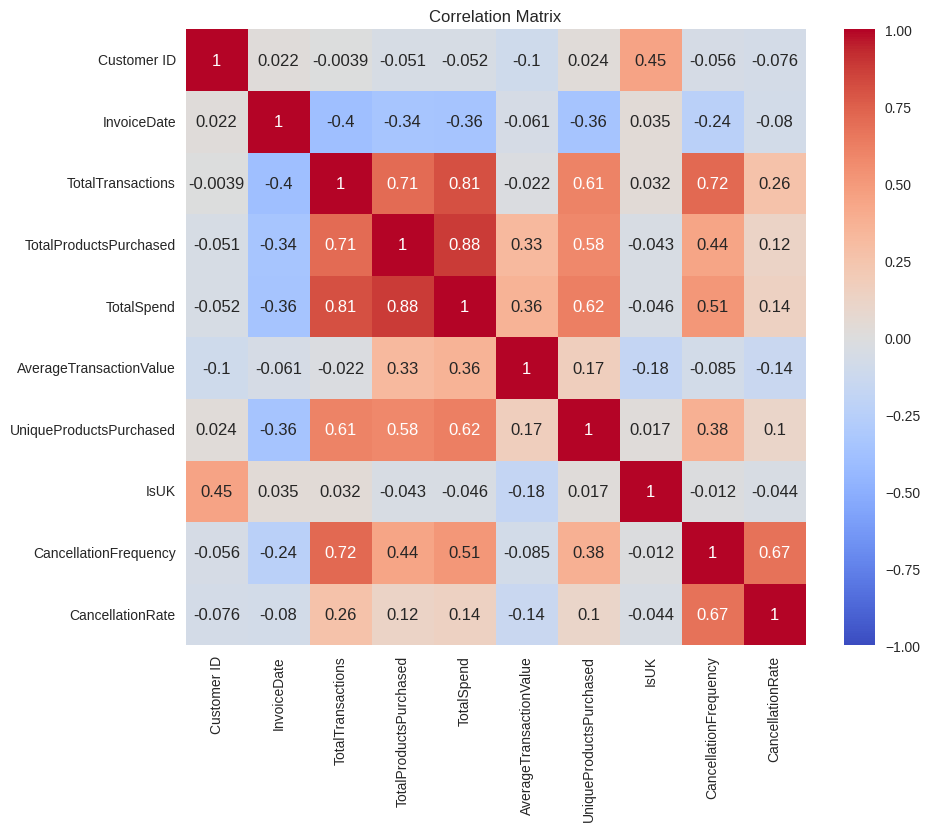

In [31]:
# Compute the correlation matrix
corr_matrix = customers_clean.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### Standardization

In [32]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
col_to_exclude = ['Customer ID', 'Is_UK']

# List of columns that need to be scaled
col_to_scale = customers_clean.columns.difference(col_to_exclude)

# Copy the cleaned dataset
customers_scaled = customers_clean.copy()

# Applying the scaler to the necessary columns in the dataset
customers_scaled[col_to_scale] = scaler.fit_transform(customers_scaled[col_to_scale])

# Display the first few rows of the scaled data
customers_scaled.head()

,Customer ID,InvoiceDate,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,IsUK,CancellationFrequency,CancellationRate
0,12346.0,0.579128,1.392877,-0.674214,-0.583909,-1.098461,-0.548482,0.306226,0.77591,0.226558
1,12347.0,-0.973693,0.404770,1.652364,1.724567,1.452866,0.709245,-3.265560,-0.56953,-0.668343
2,12348.0,-0.623829,-0.089284,1.441222,0.070146,0.224551,-0.586595,-3.265560,-0.56953,-0.668343
3,12349.0,-0.892218,-0.253968,0.567752,1.082198,2.745876,0.861697,-3.265560,0.10319,0.897734
4,12350.0,0.502446,-0.748022,-0.572255,-0.621407,0.063035,-0.688229,-3.265560,-0.56953,-0.668343


### Principal Component Analysis

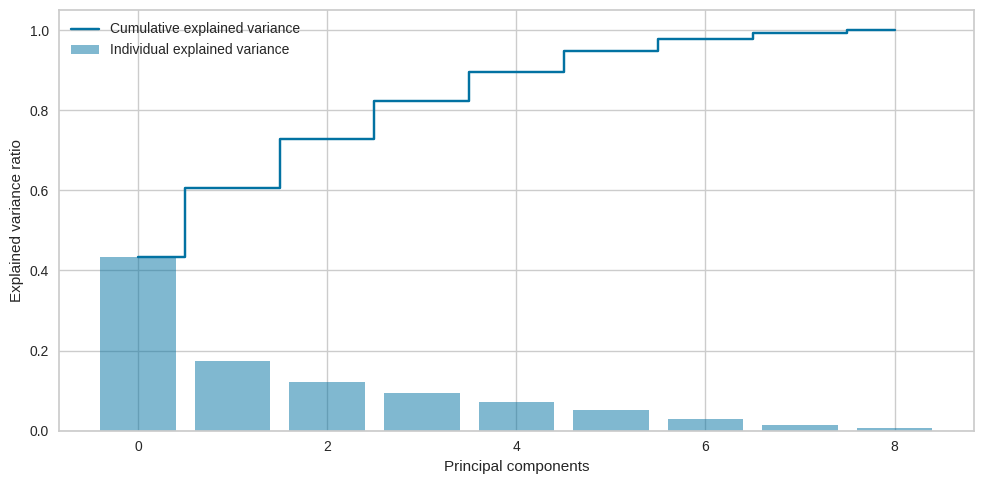

In [33]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier
customers_scaled['Customer ID'] = customers_scaled['Customer ID'].astype(str)

# Setting CustomerID as the index column
customers_scaled.set_index('Customer ID', inplace=True)

# Initialize PCA.
pca = PCA()

# Fit the PCA model
pca = pca.fit(customers_scaled)

# Transform the data to principal components
#transformed_data = pca.transform(customers_scaled)

# Visualize explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(len(cumulative_var)), cumulative_var, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [34]:
# Creating a PCA object with 5 components
pca = PCA(n_components=5)


# Fitting and transforming the original data to the new PCA dataframe
customers_pca = pca.fit_transform(customers_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customers_pca = pd.DataFrame(customers_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customers_pca.index = customers_scaled.index

customers_pca.head()

,PC1,PC2,PC3,PC4,PC5
Customer ID,,,,,
12346.0,-0.079975,-1.679733,-0.357088,0.133152,-0.815730
12347.0,2.108745,2.820614,2.394571,-1.223404,-0.858442
12348.0,0.316833,1.607180,2.383331,-1.567724,-1.187691
12349.0,1.758828,2.076729,3.599131,-0.641600,0.800891
12350.0,-1.522284,0.918528,2.664775,-1.112568,-1.374982


## Customer Segmentation Model

### K Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

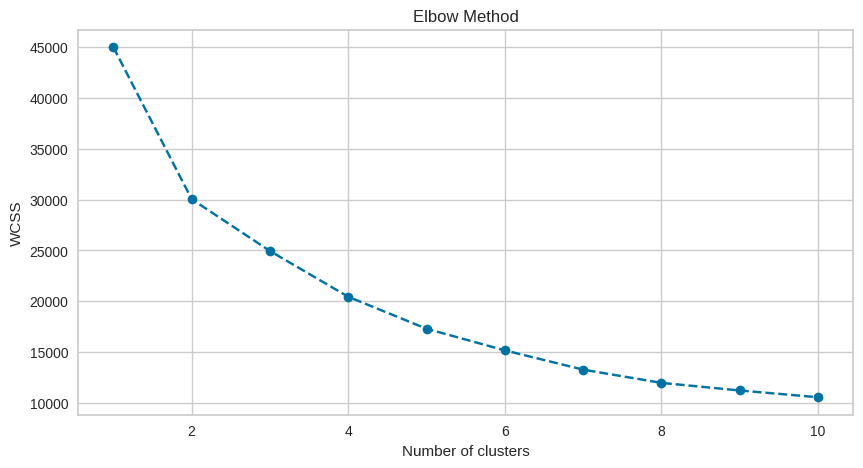

In [35]:
# Use the Elbow method to find a good number of clusters using WCSS (Within-Cluster-Sum-of-Squares)
wcss = []
for i in range(1, 11):  # checking for up to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(customers_pca)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [36]:
# Based on the Elbow graph, pick a number for k and use it for k-means clustering
chosen_k = 3
kmeans = KMeans(n_clusters=chosen_k, init='k-means++')
clusters = kmeans.fit_predict(customers_pca)

# Adding cluster information to the pca data
customers_pca['Cluster'] = clusters

customers_pca.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,PC1,PC2,PC3,PC4,PC5,Cluster
Customer ID,,,,,,
12346.0,-0.079975,-1.679733,-0.357088,0.133152,-0.815730,2
12347.0,2.108745,2.820614,2.394571,-1.223404,-0.858442,1
12348.0,0.316833,1.607180,2.383331,-1.567724,-1.187691,0
12349.0,1.758828,2.076729,3.599131,-0.641600,0.800891,2
12350.0,-1.522284,0.918528,2.664775,-1.112568,-1.374982,0


In [37]:
# Adding cluster information to the original data
customers_clean['Cluster'] = clusters

customers_clean.head()

,Customer ID,InvoiceDate,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,IsUK,CancellationFrequency,CancellationRate,Cluster
0,12346.0,326,14,69,368.36,26.311429,27,1,2.0,0.142857,2
1,12347.0,2,8,2967,4921.53,615.191250,126,0,0.0,0.000000,1
2,12348.0,75,5,2704,1658.40,331.680000,24,0,0.0,0.000000,0
3,12349.0,19,4,1616,3654.54,913.635000,138,0,1.0,0.250000,2
4,12350.0,310,1,196,294.40,294.400000,16,0,0.0,0.000000,0


In [38]:
#customers_pca.head()

### Clustering Visualization

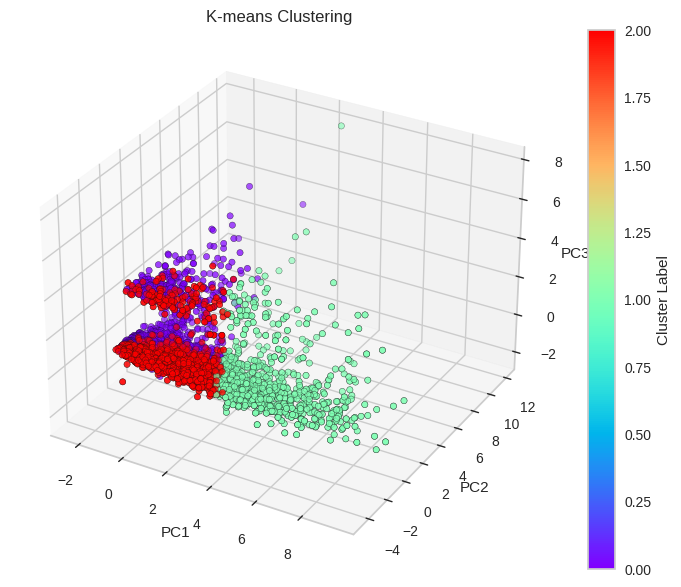

In [39]:
# Visualizing the top 3 PCs (which capture the most variance in the data)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(customers_pca['PC1'], customers_pca['PC2'], customers_pca['PC3'], c=customers_pca['Cluster'], cmap='rainbow', edgecolors='k')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("K-means Clustering")
fig.colorbar(ax.scatter(customers_pca['PC1'], customers_pca['PC2'], customers_pca['PC3'], c=customers_pca['Cluster'], cmap='rainbow', edgecolors='k')).set_label('Cluster Label')
plt.show()

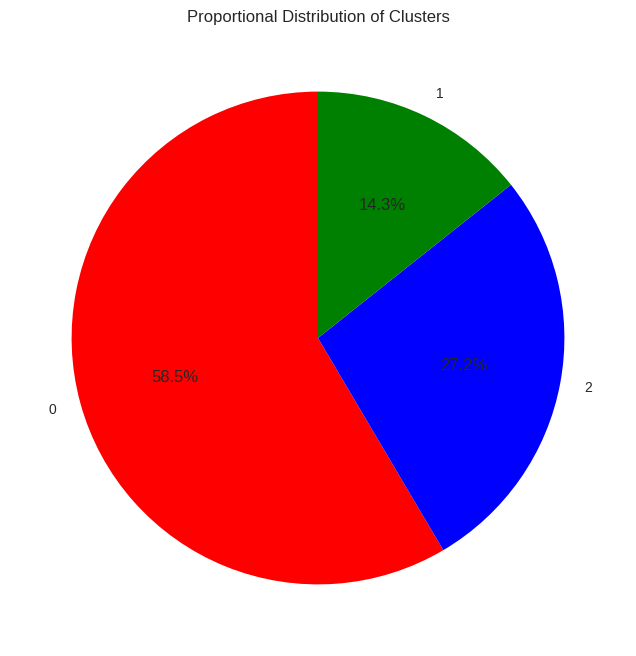

In [40]:
# Visualizing the distribution

plt.figure(figsize=(8, 8))
customers_pca['Cluster'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['red', 'blue', 'green', 'yellow', 'purple'])
plt.title('Proportional Distribution of Clusters')
plt.ylabel('')
plt.show()

### Evaluation

In [41]:
# Estimating the Silhouette score

s_score = silhouette_score(customers_pca.drop('Cluster', axis=1), customers_pca['Cluster'])
print(f"Silhouette Score: {s_score:.2f}")

Silhouette Score: 0.29


### Profiling

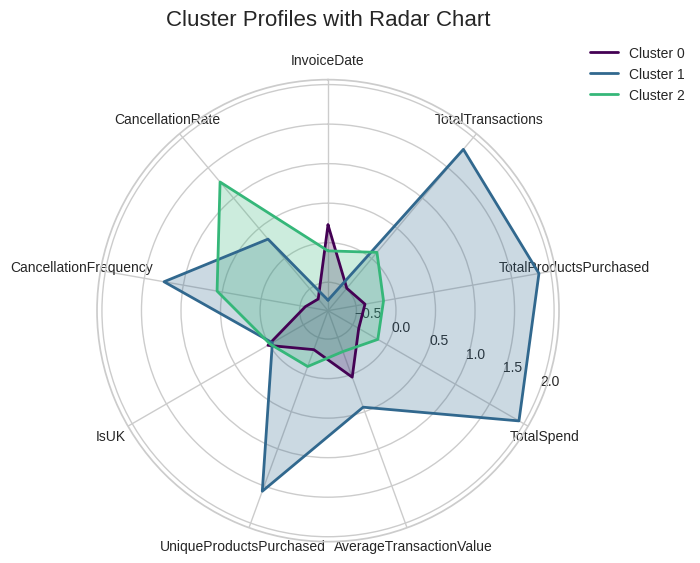

In [42]:
# Utiling a Radar chart

# Adding cluster information to the scaled data
customers_scaled['Cluster'] = clusters

# Changing the data type of 'CustomerID' to string as it is a unique identifier
#customers_scaled['Customer ID'] = customers_scaled['Customer ID'].astype(str)

# Compute the mean for each feature within each cluster.
cluster_profiles = customers_scaled.groupby('Cluster').mean()


# Function to draw chart

def plot_radar_chart(df, features):
    # Number of variables
    num_vars = len(features)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Ensure the plot is a full circle
    df = pd.concat([df, df.iloc[:, 0]], axis=1)
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for row in df.iterrows():
        color = plt.cm.viridis(row[0] / len(df.index))
        ax.plot(angles, row[1].values, color=color, linewidth=2, label=f"Cluster {row[0]}")
        ax.fill(angles, row[1].values, color=color, alpha=0.25)

    # Add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(110)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title("Cluster Profiles with Radar Chart", y=1.1, fontsize=16)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))


# Plot
plot_radar_chart(cluster_profiles, cluster_profiles.columns)

# Forecast Model

In [43]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier
#data['Customer ID'] = data['Customer ID'].astype(str)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionStatus,TotalSpend
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Completed,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Completed,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Completed,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Completed,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Completed,30.0


In [44]:
# Attach customer segment to original data
customer_to_cluster = customers_clean[['Customer ID', 'Cluster']].drop_duplicates()

clustered_data = pd.merge(data, customer_to_cluster, on='Customer ID', how='left')

clustered_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionStatus,TotalSpend,Cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Completed,83.4,2.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Completed,81.0,2.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Completed,81.0,2.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Completed,100.8,2.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Completed,30.0,2.0


In [45]:
clustered_data.describe()

,Quantity,Price,Customer ID,TotalSpend,Cluster
count,794535.000000,794535.000000,794535.000000,794535.000000,555419.000000
mean,12.648289,2.987857,15319.421003,20.605971,0.916526
std,192.041350,4.587474,1693.490264,305.807538,0.722429
min,-80995.000000,0.000000,12346.000000,-168469.600000,0.000000
25%,2.000000,1.250000,13971.000000,4.350000,0.000000
50%,5.000000,1.950000,15241.000000,11.700000,1.000000
75%,12.000000,3.750000,16791.000000,19.500000,1.000000
max,80995.000000,649.500000,18287.000000,168469.600000,2.000000


In [46]:
# Drop rows with NaN cluster values
clustered_data.dropna(subset=['Cluster'], inplace=True)
clustered_data.describe()

,Quantity,Price,Customer ID,TotalSpend,Cluster
count,555419.000000,555419.000000,555419.000000,555419.000000,555419.000000
mean,9.141733,2.986093,15386.581334,15.290245,0.916526
std,213.437124,4.638072,1663.227374,352.939170,0.722429
min,-80995.000000,0.000000,12346.000000,-168469.600000,0.000000
25%,2.000000,1.250000,14016.000000,4.250000,0.000000
50%,4.000000,1.950000,15436.000000,10.500000,1.000000
75%,12.000000,3.750000,16807.000000,17.700000,1.000000
max,80995.000000,300.130000,18287.000000,168469.600000,2.000000


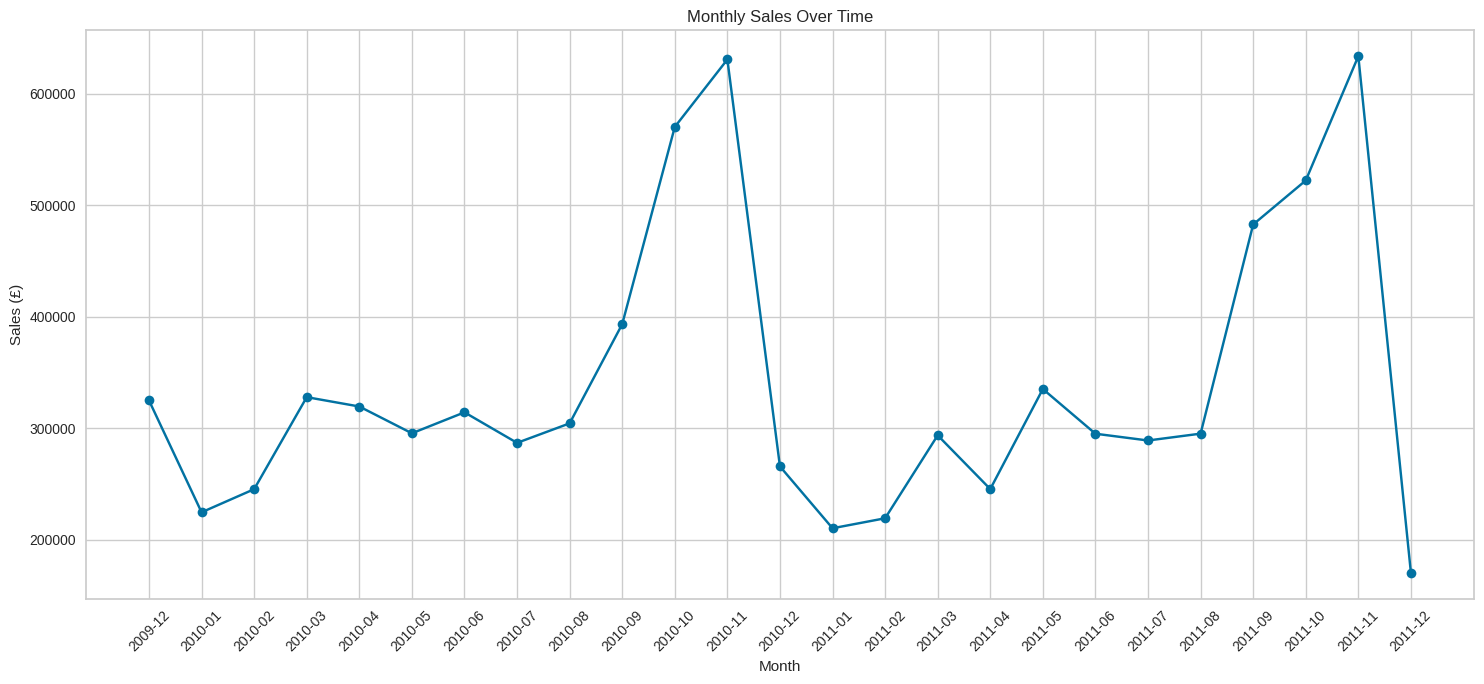

In [47]:
# Time series plot of sales over time aggregated by months

# Extract the month from InvoiceDate
clustered_data['Month'] = clustered_data['InvoiceDate'].dt.strftime('%Y-%m')  # This creates values like '2023-10'

# Group by Month
monthly_sales = clustered_data.groupby('Month').agg({'TotalSpend': 'sum'}).reset_index()

# Plot the Sales
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales['Month'], monthly_sales['TotalSpend'], marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Sales (£)')
plt.tight_layout()
plt.show()

In [48]:
# Create a Monthly Time Series for Each Segment

# Convert InvoiceDate to month-year format
clustered_data['InvoiceMonth'] = clustered_data['InvoiceDate'].dt.to_period('M')

# Aggregate data
segment_monthly_sales = clustered_data.groupby(['Cluster', 'InvoiceMonth']).agg({'TotalSpend': 'sum'}).reset_index()

# Convert the InvoiceMonth back to a datetime format for easier filtering
segment_monthly_sales['InvoiceMonth'] = segment_monthly_sales['InvoiceMonth'].astype('datetime64[ns]')


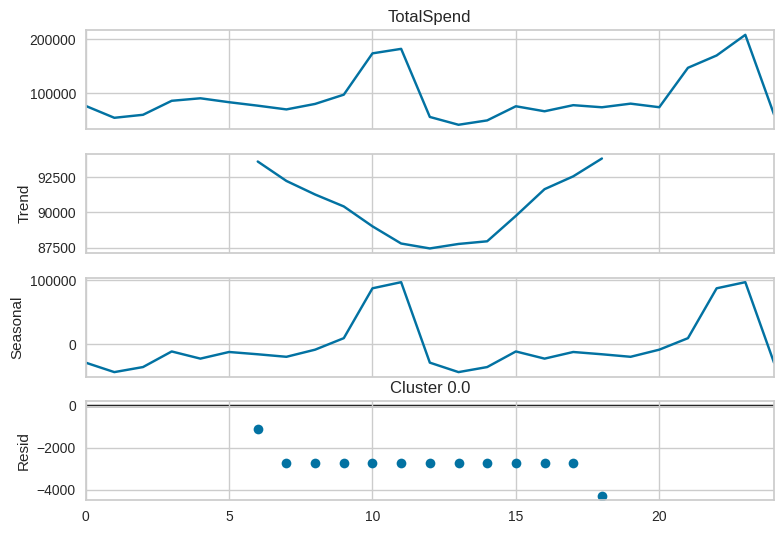

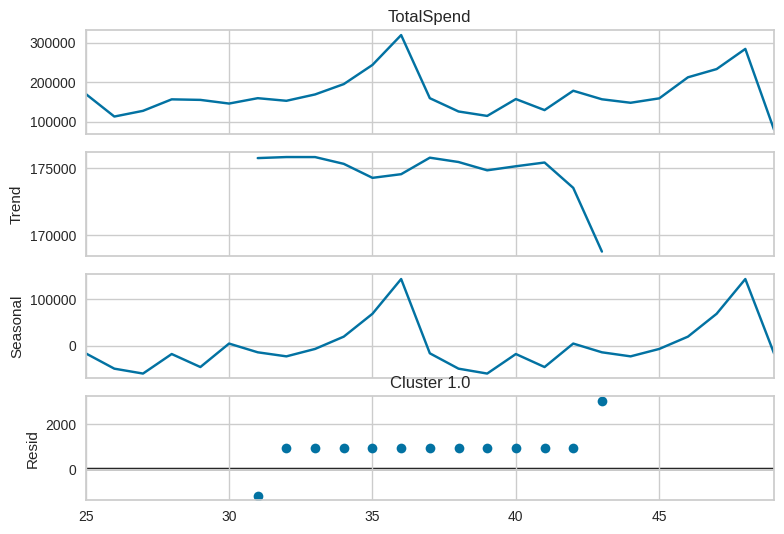

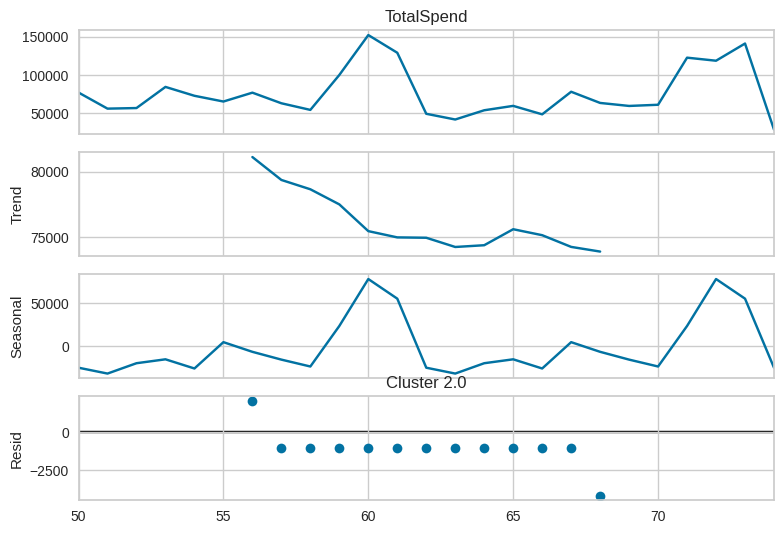

In [49]:
# Time Series Decomposition
# Before forecasting, it's beneficial to understand the components of the time series, such as trend, seasonality, and noise

# For each cluster
for cluster in segment_monthly_sales['Cluster'].unique():
    cluster_data = segment_monthly_sales[segment_monthly_sales['Cluster'] == cluster]
    result = seasonal_decompose(cluster_data['TotalSpend'], model='additive', period=12)  # Assuming yearly seasonality
    result.plot()
    plt.title(f"Cluster {cluster}")
    plt.show()

### Forecast Using ARIMA

In [50]:
# Split data into training and test sets
train_data = segment_monthly_sales[segment_monthly_sales['InvoiceMonth'] <= '2010-12-31']
test_data = segment_monthly_sales[(segment_monthly_sales['InvoiceMonth'] > '2010-12-31') & (segment_monthly_sales['InvoiceMonth'] <= '2011-12-31')]

In [51]:
# Iterate over each cluster
for cluster in train_data['Cluster'].unique():
    cluster_train = train_data[train_data['Cluster'] == cluster]['TotalSpend']
    cluster_test = test_data[test_data['Cluster'] == cluster]['TotalSpend']
    print(f"Cluster: {cluster}")
    print(f"Training size: {len(cluster_train)}")
    print(f"Testing size: {len(cluster_test)}")
    print("----------")

Cluster: 0.0
Training size: 13
Testing size: 12
----------
Cluster: 1.0
Training size: 13
Testing size: 12
----------
Cluster: 2.0
Training size: 13
Testing size: 12
----------


In [52]:
'''train_data.sort_index(inplace=True)

expected_freq = 'MS'  # For Monthly Start frequency. Adjust if your data has a different frequency.

# Check if the frequency matches the expected frequency
if not pd.infer_freq(train_data.index) == expected_freq:
    # Resample and fill missing data
    train_data = train_data.resample(expected_freq).sum()'''

"train_data.sort_index(inplace=True)\n\nexpected_freq = 'MS'  # For Monthly Start frequency. Adjust if your data has a different frequency.\n\n# Check if the frequency matches the expected frequency\nif not pd.infer_freq(train_data.index) == expected_freq:\n    # Resample and fill missing data\n    train_data = train_data.resample(expected_freq).sum()"

In [53]:
# Grid search for SARIMA

# Define the parameter grid
p = d = q = range(0, 3)  # Non-seasonal orders
P = D = Q = range(0, 3)  # Seasonal orders
s = 12  # For monthly data
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

# Search for the best parameters
lowest_aic = float('inf')
best_params = None
best_seasonal_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(train_data, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=0)
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_params = param
                best_seasonal_params = seasonal_param
        except:
            continue

print(f"Best SARIMA model is with order={best_params} and seasonal_order={best_seasonal_params} with AIC={lowest_aic}")

Best SARIMA model is with order=None and seasonal_order=None with AIC=inf


In [54]:
#print(train_data.tail())
#print(test_data.head())

Processing Cluster: 0.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide



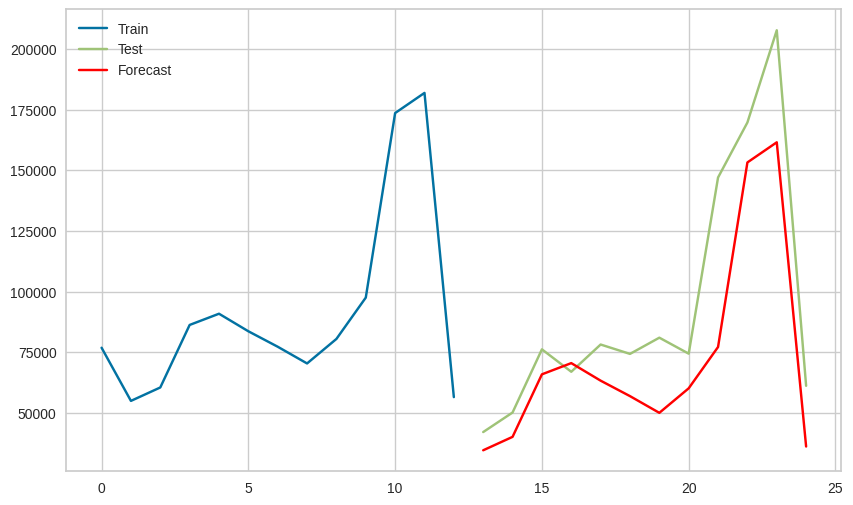

Processing Cluster: 1.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



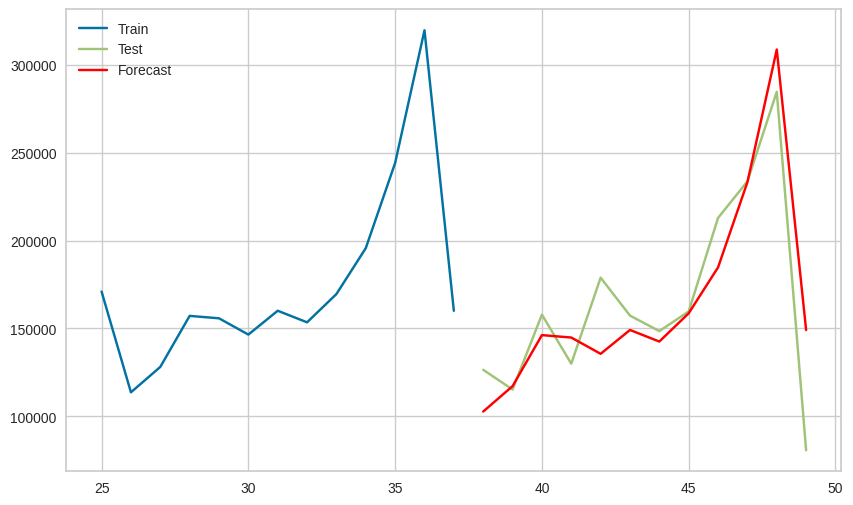

Processing Cluster: 2.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



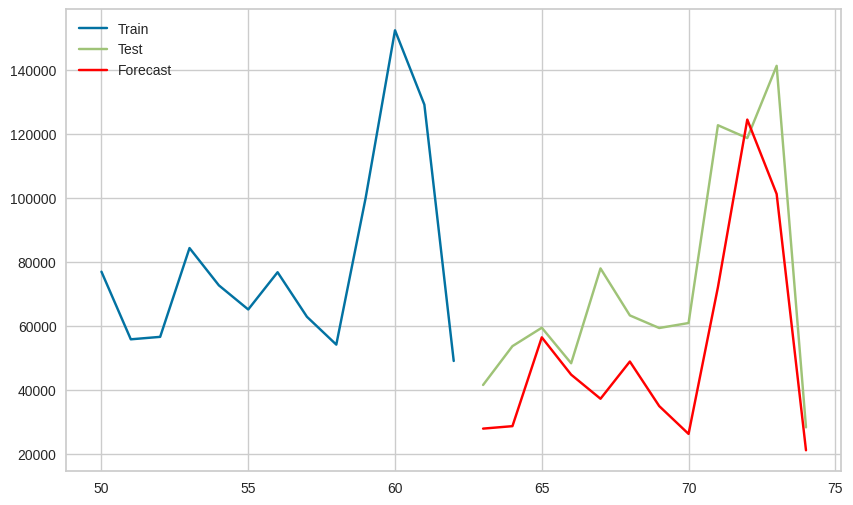

In [62]:
# Given the monthly data, we can set the seasonality (m) to 12. Let's try a seasonal ARIMA model,
# specifically SARIMA, with a seasonal order. We will start with a simple (0,1,0)(0,1,0,12) model and tweak from there.

def forecast_sarima(train_series, test_series):
    # Check for sufficient data and no NaN values
    if len(train_series) < 12 or train_series.isna().sum() > 0 or test_series.isna().sum() > 0:
        print("Skipping due to insufficient data or NaN values.")
        return None, None

    # Fit SARIMA model
    model = SARIMAX(train_series, order=(0,1,0), seasonal_order=(0,1,0,12))
    result = model.fit(disp=False)

    # Forecast
    forecast = result.get_forecast(steps=len(test_series)).predicted_mean

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_series.index, train_series.values, label='Train')
    plt.plot(test_series.index, test_series.values, label='Test')
    plt.plot(test_series.index, forecast, label='Forecast', color='red')
    plt.legend()
    plt.show()

    return forecast, result

forecasts = {}
models = {}

# Iterate over each cluster
for cluster in train_data['Cluster'].unique():
    cluster_train = train_data[train_data['Cluster'] == cluster]['TotalSpend']
    cluster_test = test_data[test_data['Cluster'] == cluster]['TotalSpend']

    print(f"Processing Cluster: {cluster}")
    forecast, model = forecast_sarima(cluster_train, cluster_test)
    if forecast is not None and model is not None:
        forecasts[cluster] = forecast
        models[cluster] = model


In [63]:
# Evaluate Forecast Accuracy:


def mape(actual, forecast):
    return 100 * (abs((actual - forecast) / actual).mean())

for cluster in train_data['Cluster'].unique():
    actual = test_data[test_data['Cluster'] == cluster]['TotalSpend'].values
    forecast = forecasts[cluster]
    error = mape(actual, forecast)
    print(f"Cluster {cluster} MAPE: {error:.2f}%")

Cluster 0.0 MAPE: 23.10%
Cluster 1.0 MAPE: 14.98%
Cluster 2.0 MAPE: 30.32%


In [57]:
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q, and d triplets
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_pdq = None
best_forecast = None
best_model = None

for param in pdq:
    try:
        model_arima = ARIMA(cluster_train, order=param)
        model_arima_fit = model_arima.fit()
        forecast = model_arima_fit.forecast(steps=len(cluster_test))

        mape = mean_absolute_percentage_error(cluster_test, forecast)
        if model_arima_fit.aic < best_aic:
            best_aic = model_arima_fit.aic
            best_pdq = param
            best_forecast = forecast
            best_model = model_arima_fit

    except:
        continue

print(f"Best ARIMA model is with pdq = {best_pdq} with AIC = {best_aic}")




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.10/dist-packages/sta

Best ARIMA model is with pdq = (0, 2, 2) with AIC = 264.76482529661234


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



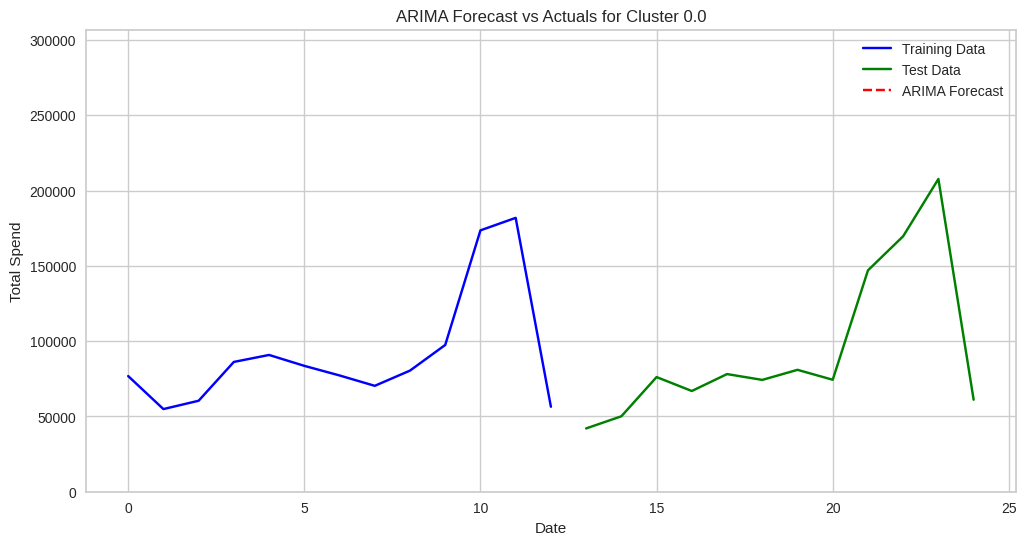

Cluster 0.0 MAPE: 11.34%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No su

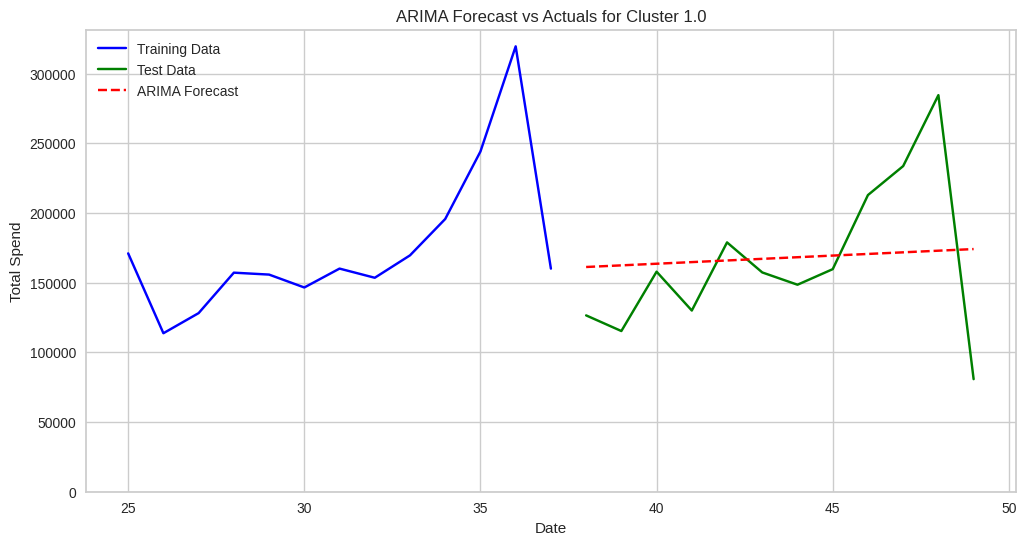

Cluster 1.0 MAPE: 0.28%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



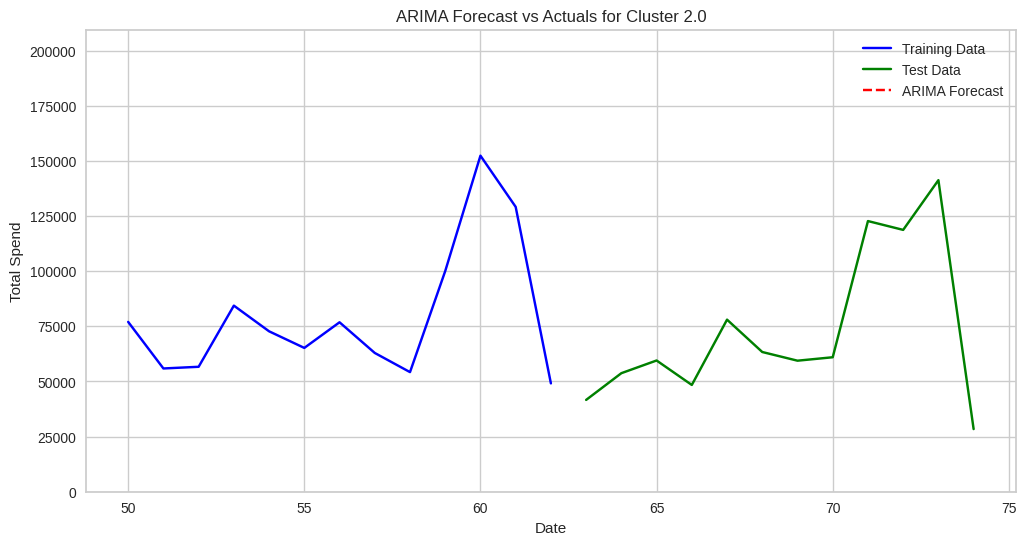

Cluster 2.0 MAPE: 9.27%


In [58]:

def forecast_arima(train, test, cluster):
    # Initialize the ARIMA model with the best parameters
    model = ARIMA(train, order=(0, 2, 1))
    model_fit = model.fit()

    # Forecast for the length of the test set
    forecast = model_fit.forecast(steps=len(test))

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data', color='blue')
    plt.plot(test.index, test, label='Test Data', color='green')
    plt.plot(test.index, forecast, label='ARIMA Forecast', color='red', linestyle='dashed')

    plt.title(f'ARIMA Forecast vs Actuals for Cluster {cluster}')
    plt.xlabel('Date')
    plt.ylabel('Total Spend')
    plt.legend()
    # Adjusting y-axis to only show positive values
    plt.ylim(bottom=0)
    plt.show()

    return forecast, model_fit

for cluster in [0.0, 1.0, 2.0]:
    cluster_train = train_data[train_data['Cluster'] == cluster]['TotalSpend']
    cluster_test = test_data[test_data['Cluster'] == cluster]['TotalSpend']

    forecast, model = forecast_arima(cluster_train, cluster_test, cluster)

    mape = mean_absolute_percentage_error(cluster_test, forecast)
    print(f"Cluster {cluster} MAPE: {mape:.2f}%")

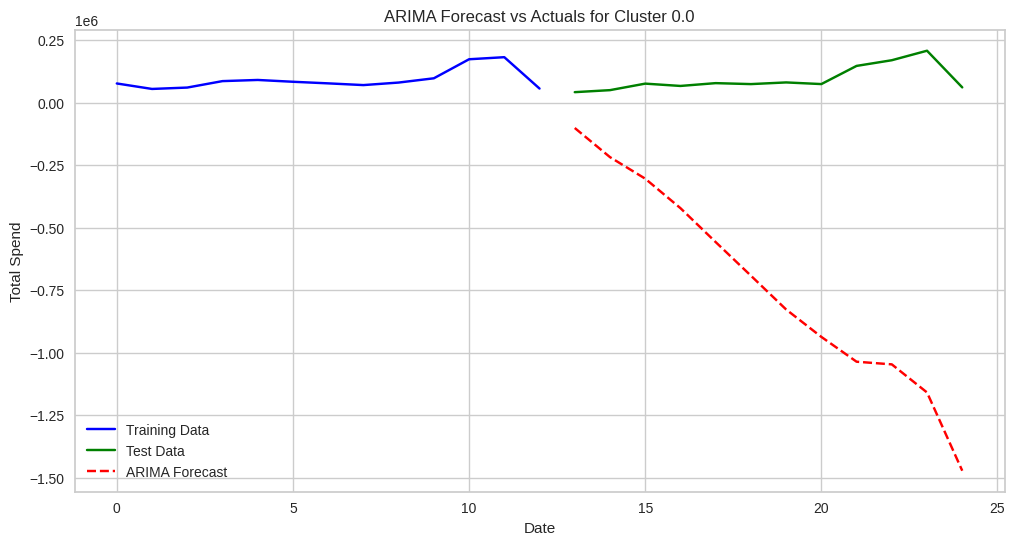

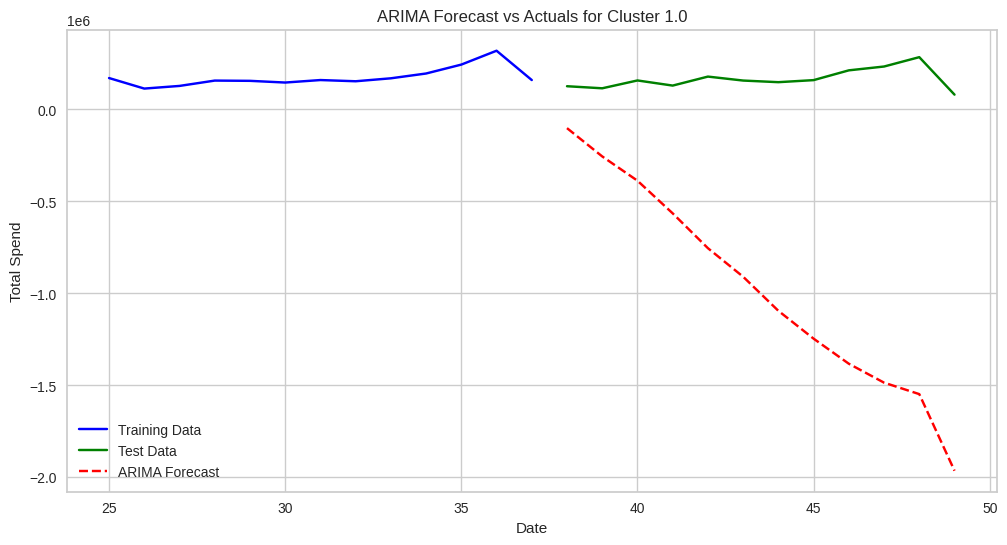

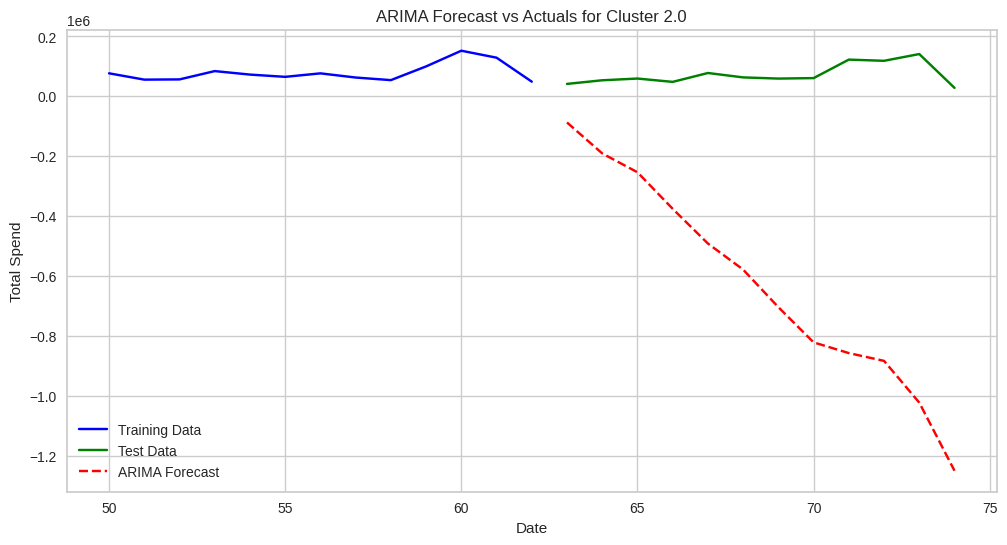

In [59]:
# Visualization

for cluster, forecast in forecasts.items():
    # Extract training and testing data for the specific cluster
    cluster_train = train_data[train_data['Cluster'] == cluster]['TotalSpend']
    cluster_test = test_data[test_data['Cluster'] == cluster]['TotalSpend']

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_train.index, cluster_train, label='Training Data', color='blue')
    plt.plot(cluster_test.index, cluster_test, label='Test Data', color='green')
    plt.plot(cluster_test.index, forecast, label='ARIMA Forecast', color='red', linestyle='dashed')

    plt.title(f'ARIMA Forecast vs Actuals for Cluster {cluster}')
    plt.xlabel('Date')
    plt.ylabel('Total Spend')
    plt.legend()
    plt.show()

### Forecast Using Prophet

<ipython-input-79-08777b6e588a>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0l1dulm2/bly1h83d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0l1dulm2/1ihezeij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15748', 'data', 'file=/tmp/tmp0l1dulm2/bly1h83d.json', 'init=/tmp/tmp0l1

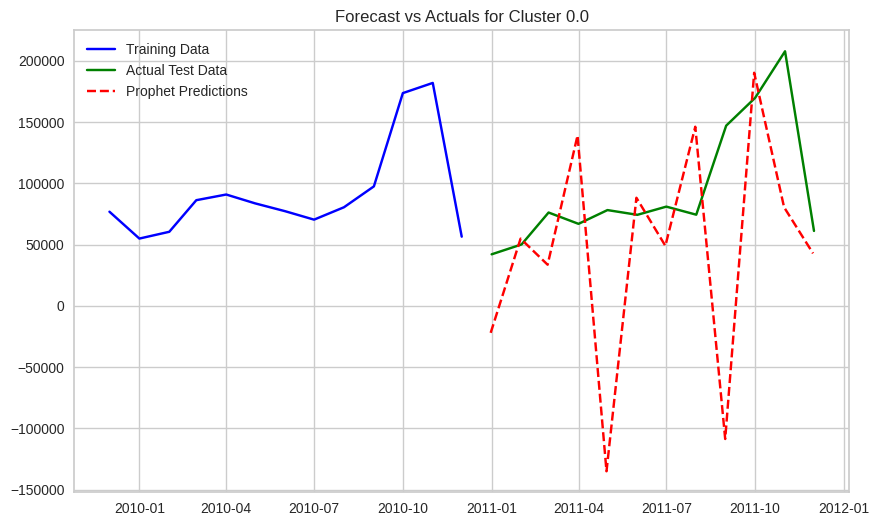

<ipython-input-79-08777b6e588a>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for Cluster 0.0 using Prophet: 2.32%


INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0l1dulm2/p1_i4cty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0l1dulm2/0t4kauwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90939', 'data', 'file=/tmp/tmp0l1dulm2/p1_i4cty.json', 'init=/tmp/tmp0l1dulm2/0t4kauwu.json', 'output', 'file=/tmp/tmp0l1dulm2/prophet_modelt_puaa4_/prophet_model-20231031222544.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:25:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


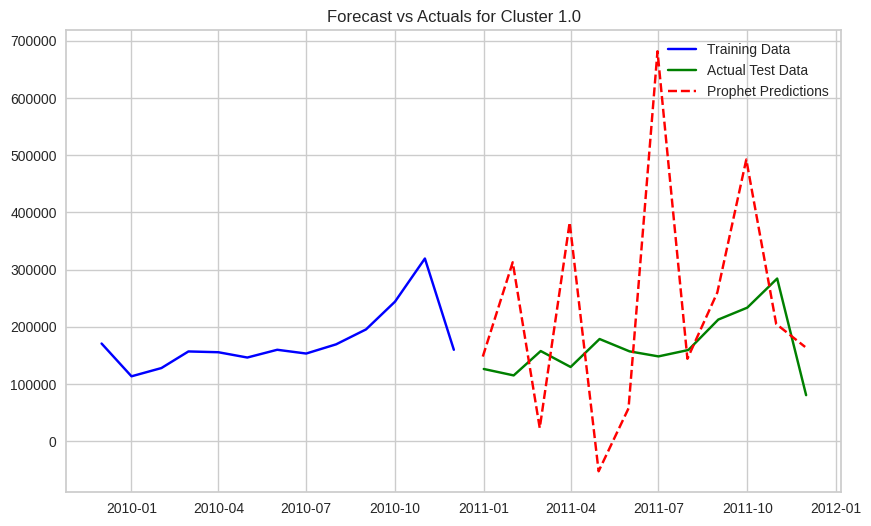

<ipython-input-79-08777b6e588a>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0l1dulm2/rb50t6e4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0l1dulm2/if0z29el.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8979', 'data', 'file=/tmp/tmp0l1dulm2/rb50t6e4.json', 'init=/tmp/tmp0l1d

MAPE for Cluster 1.0 using Prophet: 1.99%


22:25:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


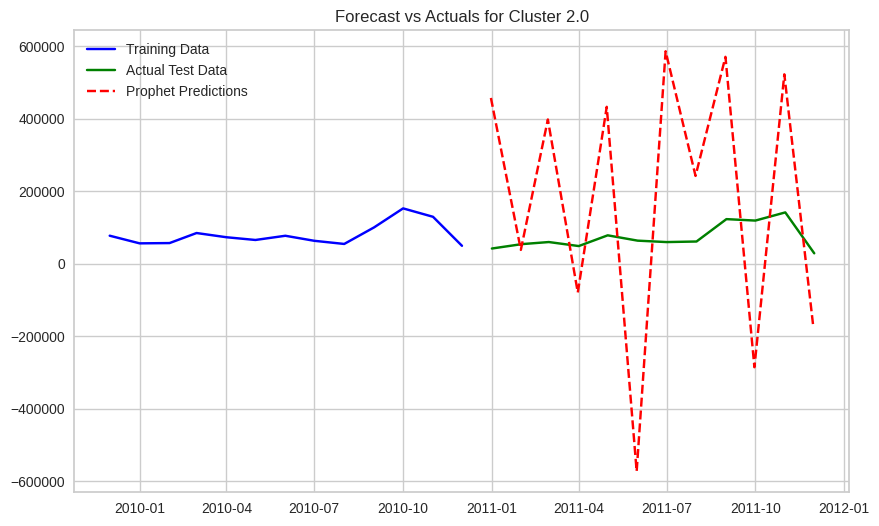

MAPE for Cluster 2.0 using Prophet: 1.00%
Summary of MAPE values for each cluster:
Cluster 0.0: 2.32%
Cluster 1.0: 1.99%
Cluster 2.0: 1.00%


In [79]:
clusters = train_data['Cluster'].unique()

# Store MAPE values for each cluster
mape_values = {}

for cluster in clusters:
    # Filter data for the current cluster
    cluster_train = train_data[train_data['Cluster'] == cluster]
    cluster_test = test_data[test_data['Cluster'] == cluster]

    # Prepare the data for Prophet
    prophet_train = cluster_train[['InvoiceMonth', 'TotalSpend']]
    prophet_train.columns = ['ds', 'y']
    prophet_train['ds'] = pd.to_datetime(prophet_train['ds'])

    # Initialize and fit the model
    model_prophet = Prophet(yearly_seasonality=True)
    model_prophet.fit(prophet_train)

    # Create a dataframe for future predictions
    future = model_prophet.make_future_dataframe(periods=len(cluster_test), freq='M')
    forecast_prophet = model_prophet.predict(future)

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot actual values
    ax.plot(prophet_train['ds'], prophet_train['y'], label='Training Data', color='blue')
    ax.plot(cluster_test['InvoiceMonth'], cluster_test['TotalSpend'], label='Actual Test Data', color='green')

    # Plot predicted values
    forecast_dates = forecast_prophet['ds'][-len(cluster_test):]
    ax.plot(forecast_dates, y_pred_prophet, label='Prophet Predictions', color='red', linestyle='--')

    ax.legend()
    plt.title(f"Forecast vs Actuals for Cluster {cluster}")
    plt.show()

    # Compute MAPE
    y_true = cluster_test['TotalSpend'].values
    y_pred_prophet = forecast_prophet['yhat'][-len(cluster_test):].values
    mape_prophet = mean_absolute_percentage_error(y_true, y_pred_prophet)

    print(f"MAPE for Cluster {cluster} using Prophet: {mape_prophet:.2f}%")
    mape_values[cluster] = mape_prophet

print("Summary of MAPE values for each cluster:")
for cluster, mape in mape_values.items():
    print(f"Cluster {cluster}: {mape:.2f}%")